c:\Users\Venkat\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


c:\Users\Venkat\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Venkat\.cache\huggingface\hub\models--microsoft--resnet-50. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
c:\Users\Venkat\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\model

Original Train counts per class: {0: 56, 1: 56}
Augmented Train counts per class: {0: 168, 1: 168}
Test counts per class: {0: 14, 1: 14}


Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([2, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model Architecture:
 ResNetForImageClassification(
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBottleNeckLayer(
              (shortcut): ResNetShortCut(
                (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (layer): Sequential(
                (0): ResNetConvLayer(
                  (c

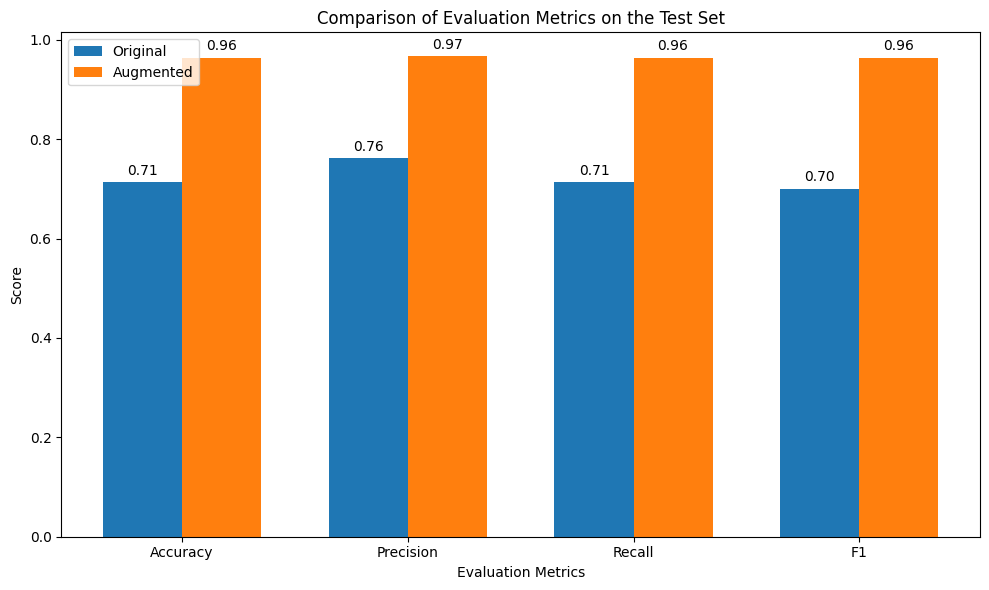


Explanation:
Both experiments start with the same initial model weights to ensure a fair comparison.
Data augmentation increases the number of training images (from 56 per class to 168 per class), which can help improve generalization.
If the augmented training yields better evaluation metrics on the test set, it indicates improved robustness to variations in the data.
If the results are similar or worse, further tuning of the augmentation parameters, training hyperparameters, or more training epochs might be needed.


In [1]:
import os
import copy
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from transformers import AutoFeatureExtractor, ResNetForImageClassification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ----------------------------
# 1. Setup: Reproducibility & Device
# ----------------------------
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----------------------------
# 2. Data Preparation
# ----------------------------
# Paths to datasets (adjust these paths to your dataset locations)
original_train_dir = "original_dataset/train"
original_test_dir = "original_dataset/test"
augmented_train_dir = "dataset/train"
# We'll use the original test set for evaluation.
test_dir = original_test_dir

# Load a feature extractor from Hugging Face to obtain normalization parameters
feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/resnet-50")

# Define transforms for training and testing (resize, crop, normalize)
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

# Create datasets using ImageFolder (requires folder structure: <root>/<class>/images)
original_train_dataset = datasets.ImageFolder(root=original_train_dir, transform=train_transform)
augmented_train_dataset  = datasets.ImageFolder(root=augmented_train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)

# Create DataLoaders for training and testing
batch_size = 32
original_train_loader = DataLoader(original_train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
augmented_train_loader = DataLoader(augmented_train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Function to count images per class in a dataset
def count_dataset_images(dataset):
    counts = {}
    for _, label in dataset.samples:
        counts[label] = counts.get(label, 0) + 1
    return counts

print("Original Train counts per class:", count_dataset_images(original_train_dataset))
print("Augmented Train counts per class:", count_dataset_images(augmented_train_dataset))
print("Test counts per class:", count_dataset_images(test_dataset))

# ----------------------------
# 3. Model Initialization
# ----------------------------
# Load the pretrained ResNet-50 model for image classification.
# The pretrained model is originally built for 1000 classes (ImageNet).
# To use it for 2 classes, we set num_labels=2 and add ignore_mismatched_sizes=True
# so that the classification head is reinitialized.
model = ResNetForImageClassification.from_pretrained(
    "microsoft/resnet-50",
    num_labels=2,
    ignore_mismatched_sizes=True
)
model.to(device)

print("\nModel Architecture:\n", model)

# Save the initial state so both experiments start from the same weights
initial_state_dict = copy.deepcopy(model.state_dict())

# ----------------------------
# 4. Training and Evaluation Functions
# ----------------------------
def train_model(model, dataloader, criterion, optimizer, device, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images).logits  # The model returns a ModelOutput; we use .logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
        epoch_loss = running_loss / len(dataloader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
    return model

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images).logits
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    
    return accuracy, precision, recall, f1

# ----------------------------
# 5. Experiments: Training on Original vs. Augmented Data
# ----------------------------
num_epochs = 5
learning_rate = 1e-4
criterion = nn.CrossEntropyLoss()

results = {}

# --- Experiment 1: Train on Original (Non-Augmented) Dataset ---
print("\n--- Training on Original (Non-Augmented) Dataset ---")
# Reset model to initial weights
model.load_state_dict(initial_state_dict)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model = train_model(model, original_train_loader, criterion, optimizer, device, num_epochs=num_epochs)
acc_orig, prec_orig, rec_orig, f1_orig = evaluate_model(model, test_loader, device)
results['Original'] = {'Accuracy': acc_orig, 'Precision': prec_orig, 'Recall': rec_orig, 'F1': f1_orig}

# --- Experiment 2: Train on Augmented Dataset ---
print("\n--- Training on Augmented Dataset ---")
# Reset model to initial weights
model.load_state_dict(initial_state_dict)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model = train_model(model, augmented_train_loader, criterion, optimizer, device, num_epochs=num_epochs)
acc_aug, prec_aug, rec_aug, f1_aug = evaluate_model(model, test_loader, device)
results['Augmented'] = {'Accuracy': acc_aug, 'Precision': prec_aug, 'Recall': rec_aug, 'F1': f1_aug}

# ----------------------------
# 6. Display and Plot Evaluation Metrics
# ----------------------------
print("\nEvaluation Metrics on Test Set:")
for exp_name, metrics in results.items():
    print(f"\n{exp_name} Training:")
    print(f"  Accuracy : {metrics['Accuracy']:.4f}")
    print(f"  Precision: {metrics['Precision']:.4f}")
    print(f"  Recall   : {metrics['Recall']:.4f}")
    print(f"  F1 Score : {metrics['F1']:.4f}")

# Plot a bar graph comparing the metrics from both experiments
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1']
original_metrics = [results['Original'][m] for m in metrics_names]
augmented_metrics = [results['Augmented'][m] for m in metrics_names]

x = np.arange(len(metrics_names))  # Label locations
width = 0.35  # Bar width

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, original_metrics, width, label='Original')
bars2 = ax.bar(x + width/2, augmented_metrics, width, label='Augmented')

ax.set_xlabel("Evaluation Metrics")
ax.set_ylabel("Score")
ax.set_title("Comparison of Evaluation Metrics on the Test Set")
ax.set_xticks(x)
ax.set_xticklabels(metrics_names)
ax.legend()

# Function to attach value labels to each bar
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Offset text vertically by 3 points
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars1)
autolabel(bars2)

plt.tight_layout()
plt.show()

# ----------------------------
# 7. Explanation
# ----------------------------
print("\nExplanation:")
print("Both experiments start with the same initial model weights to ensure a fair comparison.")
print("Data augmentation increases the number of training images (from 56 per class to 168 per class), which can help improve generalization.")
print("If the augmented training yields better evaluation metrics on the test set, it indicates improved robustness to variations in the data.")
print("If the results are similar or worse, further tuning of the augmentation parameters, training hyperparameters, or more training epochs might be needed.")
